# Google news scraper
Get the number of search results per day for any search term


In [1]:
import bs4
import requests
import pandas as pd
import datetime as dt
import time
from random import randint

In [2]:
numDays = 400 # number of days to scape, starting on 1/1/2014     
    
headers = {'user-agent': 'Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.36'}

#generate search query for google news search
qBust = """fentanyl+AND+("bust"+OR+"seized"+OR+"drug+sweep")"""
qDeath = """fentanyl+AND+("death"+OR+"overdose")"""
qArrest = """fentanyl+AND+("arrested"+OR+"arrests")"""
qDeathBust = [];
qDeathHits = [];
qArrestHits = [];
# assign search query
q = qDeath
print 'Search query = '+q

# starting date for the search
firstDate = dt.datetime(2014, 1, 1) 

# extract number of hits
numHits = []
for day in range(0,numDays):
    # genearate search date from number of days after 1/1/2014
    d = firstDate + dt.timedelta(day)
    searchBeginDate = d.strftime("%m/%d/%Y")
    searchEndDate = searchBeginDate
    print 'Scraping Google News on '+searchBeginDate

    url=("https://www.google.com/search?"
         "q=%s"
         "&hl=en&gl=us&authuser=0&source=lnt"
         "&tbs=cdr:1,cd_min:%s,cd_max:%s&tbm=nws") % (q,searchBeginDate, searchEndDate)

    # run google news search
    while True:
        req = requests.get(url, headers=headers)
        sleeptime = 1 + randint(0,5)
        print 'wait for '+str(sleeptime)+' seconds'
        time.sleep(sleeptime)
        if req.status_code == 200: #successful query
            #print 'success'
            break
        if req.status_code == 503: #successful query
            print "Error 503: Service Unavailable, day=" + str(day)
            time.sleep(30)
            
    # extract number of hits
    soup = bs4.BeautifulSoup(req.text, "html.parser")
    try:
        numHitsText = soup.find('div',{'id':'resultStats'}).text
    except:
        numHitsText = "No, 0 results, there was some error!!"
        print "Error when parsing google search hits: Code 1:"
    
    # convert to integer number
    print numHitsText
    try:
        n = [int(num) for num in numHitsText.split() if num.isdigit()]
        print 'The number if hits =' + str(n)
        numHits.append( n )
    except:
        print "Error when parsing google search hits: Code 2:"
        print numHitsText
    print
        
# now save number of hits to cvs file
hitDates = []
for ii in range(0,len(numHits)):
    hitDates.append( firstDate + dt.timedelta(ii) )

df_numHits = pd.DataFrame({'numHits':numHits},index=hitDates)

fn = q;
fn = fn.replace('+','')
fn = fn.replace('"','')
fn = fn.replace('(','')
fn = fn.replace(')','')
fn = fn+'_'+hitDates[0].strftime("%Y_%m_%d")
fn = fn+'_to_'+hitDates[len(numHits)-1].strftime("%Y_%m_%d")
fn = fn+'.csv'

print "Number of hits written to " + fn
print df_numHits
df_numHits.to_csv(fn,index=True)

       

Search query = fentanyl+AND+("death"+OR+"overdose")
Scraping Google News on 01/01/2014
wait for 5 seconds
6 results (0.22 seconds) 
The number if hits =[6]

Scraping Google News on 01/02/2014
wait for 1 seconds
Error when parsing google search hits: Code 1:
No, 0 results, there was some error!!
The number if hits =[0]

Scraping Google News on 01/03/2014
wait for 4 seconds
4 results (0.17 seconds) 
The number if hits =[4]

Scraping Google News on 01/04/2014
wait for 6 seconds
3 results (0.19 seconds) 
The number if hits =[3]

Scraping Google News on 01/05/2014
wait for 3 seconds
About 0 results (0.17 seconds) 
The number if hits =[0]

Scraping Google News on 01/06/2014
wait for 1 seconds
About 0 results (0.17 seconds) 
The number if hits =[0]

Scraping Google News on 01/07/2014
wait for 2 seconds
2 results (0.20 seconds) 
The number if hits =[2]

Scraping Google News on 01/08/2014
wait for 3 seconds
5 results (0.19 seconds) 
The number if hits =[5]

Scraping Google News on 01/09/2014
wa

KeyboardInterrupt: 

In [4]:
## now save number of hits to cvs file
# print numHits
hitDates = []
for ii in range(0,len(numHits)):
    hitDates.append( firstDate + dt.timedelta(ii) )

df_numHits = pd.DataFrame({'numHits':numHits},index=hitDates)

fn = q;
fn = fn.replace('+','')
fn = fn.replace('"','')
fn = fn.replace('(','')
fn = fn.replace(')','')
fn = fn+'_'+hitDates[0].strftime("%Y_%m_%d")
fn = fn+'_to_'+hitDates[len(numHits)-1].strftime("%Y_%m_%d")
fn = fn+'.csv'

print "Number of hits written to " + fn
df_numHits.to_csv(fn,index=True)


Number of hits written to fentanylANDdeathORoverdose_2014_01_01_to_2014_01_24.csv


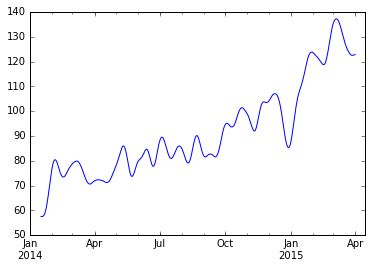

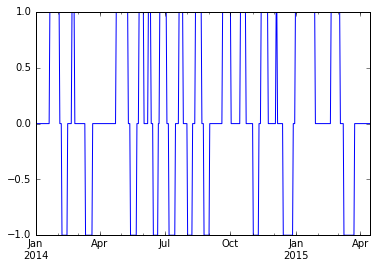

In [27]:
## plot the google news hits
import pandas as pd
import pylab as plt
import datetime as dt
import math
%matplotlib inline

numberOfGNhits = pd.read_csv("./data/fentanylANDdeathORoverdose_2014_01_01_to_2015_04_015.csv")

datesNumHits=[]
numberOfHits = []
fig = plt.figure()
for hit in numberOfGNhits['date']:
    datesNumHits.append (dt.datetime.strptime(hit,"%Y-%m-%d"))

numHitsList = []
for hit in numberOfGNhits['numHits']:
    hit=hit.replace('[','')
    hit=hit.replace(']','')
    numHitsList.append( int(hit) )
    
df_hits=pd.Series(numHitsList, index = datesNumHits)

# smoothing
smoothWindowWidth = 30
df_hitsSmooth=df_hits.rolling(smoothWindowWidth,center=True,win_type='blackman').mean()


# convert to raising/falling/constant time series
hitsConstantDetectrange = 0.5
hitsUpDown = []
for gradHit in df_hitsSmooth.diff():
    if math.isnan(gradHit):
        hitsUpDown.append(0)
    elif gradHit>=hitsConstantDetectrange:
        hitsUpDown.append(1)
    elif gradHit<=-hitsConstantDetectrange:
        hitsUpDown.append(-1)
    else:
        hitsUpDown.append(0)
df_hitsUpDown=pd.Series(hitsUpDown, index = datesNumHits)

# plot
fig = plt.figure()
df_hitsSmooth.plot()
fig = plt.figure()
df_hitsUpDown.plot()

